**Bucket FICO Scores**



In [18]:
import numpy as np
import pandas as pd
from scipy.stats import binom
import matplotlib.pyplot as plt

In [19]:
# Load data
FICO_df = pd.read_csv('//content/drive/MyDrive/JP Morgan Quantitative research/Task 3 and 4_Loan_Data.csv')
FICO_df

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0
...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0


In [21]:
# Initialize 5 buckets for simplicity
num_buckets = 4
FICO_df['bucket'] = pd.cut(FICO_df['fico_score'], bins=num_buckets, labels=False)

FICO_df

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,bucket
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0,1
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0,1
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0,1
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0,2
...,...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0,2
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0,1
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0,1
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0,2


**Initialize the bucket boundaries**



Initial log-Likelihood: -13.463435690611483


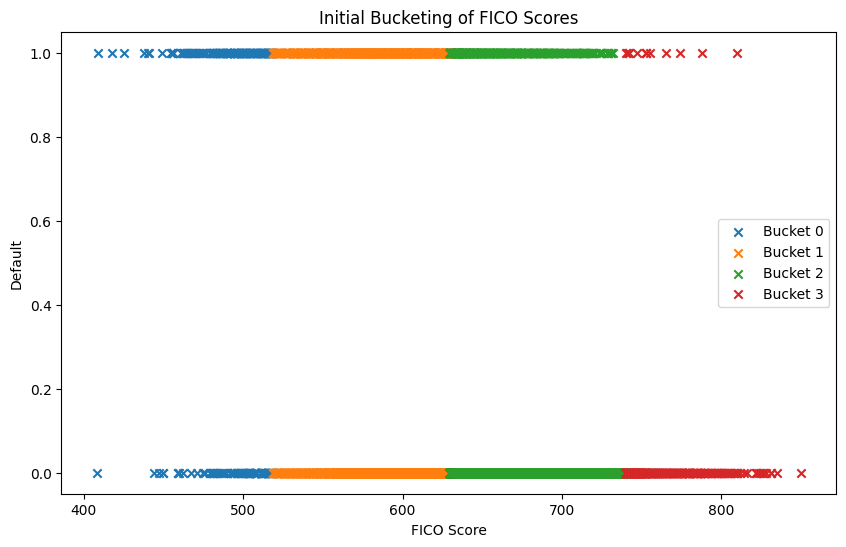

In [22]:
# Calculate the initial log-likelihood

def calculate_log_likelihood(data):
    log_likelihood = 0
    for b in range(num_buckets):
        bucket_data = FICO_df[FICO_df['bucket'] == b]
        if not bucket_data.empty:
            ni = len(bucket_data)
            ki = bucket_data['default'].sum()
            pi = ki/ni if ni > 0 else 0
            log_likelihood += binom.logpmf(ki,ni,pi)
    return log_likelihood

initial_log_likelihood = calculate_log_likelihood(FICO_df)

print(f"Initial log-Likelihood: {initial_log_likelihood}")

# Plotting the initial bucketing
plt.figure(figsize=(10, 6))
for b in range(num_buckets):
    bucket_data = FICO_df[FICO_df['bucket'] == b]
    plt.scatter(bucket_data['fico_score'], bucket_data['default'], label=f'Bucket {b}', marker = 'x')
plt.xlabel('FICO Score')
plt.ylabel('Default')
plt.legend()
plt.title('Initial Bucketing of FICO Scores')
plt.show()

**Bucket Optimization**

In [25]:
def optimize_buckets(data, num_buckets, max_iterations=100):
    boundaries = np.linspace(FICO_df['fico_score'].min(), FICO_df['fico_score'].max(), num_buckets + 1)
    best_log_likelihood = calculate_log_likelihood(data)
    improved = True
    iteration = 0

    while improved and iteration < max_iterations:
        improved = False
        for i in range(1,len(boundaries)-1):
            original_boundary = boundaries[i]
            # Try shifting the boundary up and down
            for shift in [-10,10]:
                boundaries[i] += shift
                FICO_df['bucket'] = pd.cut(FICO_df['fico_score'], bins=boundaries, labels=False, include_lowest=True)
                new_log_likelihood = calculate_log_likelihood(data)
                if new_log_likelihood > best_log_likelihood:
                    best_log_likelihood = new_log_likelihood
                    improved = True
                else:
                    boundaries[i] = original_boundary # Revert if no improvement

        iteration +=1
        print(f"Iteration {iteration}, log-Likelihood: {best_log_likelihood}")

    return boundaries

In [26]:
# Optimize the buckets
final_boundaries = optimize_buckets(FICO_df, num_buckets)

# Update the data with the optimized buckets
FICO_df['bucket'] = pd.cut(FICO_df['fico_score'], bins=final_boundaries, labels=False, include_lowest=True)
final_boundaries


Iteration 1, log-Likelihood: -13.231444113073735
Iteration 2, log-Likelihood: -12.903555593221299
Iteration 3, log-Likelihood: -12.748672117234278
Iteration 4, log-Likelihood: -12.748672117234278


array([408. , 518.5, 629. , 759.5, 850. ])

**Decided we need to optimize the buckets**

In [29]:
def optimize_buckets_count(data, min_buckets, max_buckets):
    best_overall_likelihood = float('-inf')
    best_buckets_count = min_buckets
    best_boundaries = None

    for num_buckets in range(min_buckets, max_buckets + 1):

        print(f"testing {num_buckets} buckets...")
        boundaries = np.linspace(data['fico_score'].min(), FICO_df['fico_score'].max(), num_buckets + 1)
        data['bucket'] = pd.cut(data['fico_score'], bins=boundaries, labels=False, include_lowest=True)
        initial_log_likelihood = calculate_log_likelihood(data)

        boundaries = optimize_buckets(data, num_buckets) # optimize boundaries
        data['bucket'] = pd.cut(data['fico_score'], bins=boundaries, labels=False, include_lowest=True)
        final_likelihood = calculate_log_likelihood(data)

        print(f"Boundaries for {num_buckets} buckets: {boundaries}")
        print(f"log-Likelihood for {num_buckets} buckets: {final_likelihood}")

        if final_likelihood > best_overall_likelihood:
            best_overall_likelihood = final_likelihood
            best_buckets_count = num_buckets
            best_boundaries = boundaries

    return best_buckets_count, best_boundaries, best_overall_likelihood

# Plug
best_count, best_boundaries, best_likelihood = optimize_buckets_count(FICO_df, 4, 10)
print(f"Best number of buckets: {best_count}, with log-Likelihood: {best_likelihood}")

testing 4 buckets...
Iteration 1, log-Likelihood: -13.231444113073735
Iteration 2, log-Likelihood: -12.903555593221299
Iteration 3, log-Likelihood: -12.748672117234278
Iteration 4, log-Likelihood: -12.748672117234278
Boundaries for 4 buckets: [408.  518.5 629.  759.5 850. ]
log-Likelihood for 4 buckets: -12.903555593221299
testing 5 buckets...
Iteration 1, log-Likelihood: -13.979545291440058
Iteration 2, log-Likelihood: -13.979545291440058
Boundaries for 5 buckets: [408.  496.4 584.8 673.2 761.6 850. ]
log-Likelihood for 5 buckets: -14.171340233241736
testing 6 buckets...
Iteration 1, log-Likelihood: -13.673687492432771
Iteration 2, log-Likelihood: -13.673687492432771
Boundaries for 6 buckets: [408.         481.66666667 555.33333333 629.         702.66666667
 776.33333333 850.        ]
log-Likelihood for 6 buckets: -13.908722321592865
testing 7 buckets...
Iteration 1, log-Likelihood: -13.057220612790339
Iteration 2, log-Likelihood: -13.057220612790339
Boundaries for 7 buckets: [408.   

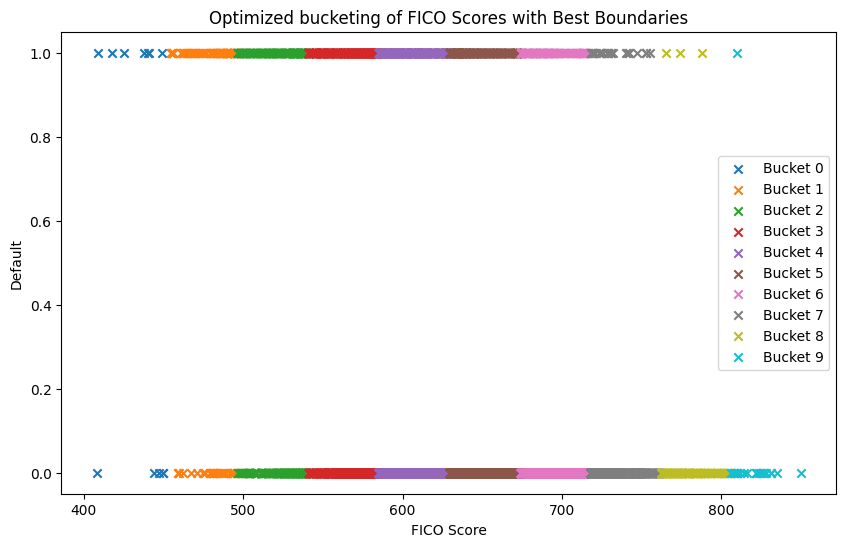

In [30]:
# Plotting the final bucketing

num_buckets = best_count
final_boundaries = best_boundaries

# Update the data frame with the optimal bucket assignment
FICO_df['bucket'] = pd.cut(FICO_df['fico_score'], bins=final_boundaries, labels=False, include_lowest=True)

plt.figure(figsize=(10, 6))
for b in range(num_buckets):
    bucket_data = FICO_df[FICO_df['bucket'] == b]
    plt.scatter(bucket_data['fico_score'], bucket_data['default'], label=f'Bucket {b}', marker = 'x')
plt.xlabel('FICO Score')
plt.ylabel('Default')
plt.legend()
plt.title('Optimized bucketing of FICO Scores with Best Boundaries')
plt.show()